In [1]:
# Import necessary libraries
%matplotlib inline
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Top of Atmospheric (TOA) spectral radiance
# TOA (L) = ML * Qcal + AL 
def cal_TOA_radiance(Radiance_mult_band_10, rbx, Rad_add_band_10):
    Toa = (Radiance_mult_band_10 * rbx) + Rad_add_band_10
    return Toa

# Top of Atmospheric (TOA) spectral reflectance
# TOA (p) = Mp * Qcal + Ap
def cal_TOA_reflectance(Reflectance_mult_band_x, rbx, Ref_add_band_x):
    Toa_ref = (Reflectance_mult_band_x * rbx) + Ref_add_band_x        # without SunElevation
    return Toa_ref

# calculate Brightness Temperature
# BT = (K2 / (ln (K1 / L) + 1)) − 273.15   : L = TOA
def cal_BT(K1_constant_band_10, K2_constant_band_10, Toa):
    print(Toa)
    print(Toa.size)
    b1 = (K1_constant_band_10/Toa) + 1
    b2 = (np.log(b1))
    BT = (K2_constant_band_10 / b2) - 273.15
    return BT

# NDVI = (Band 5 – Band 4) / (Band 5 + Band 4)
def cal_ndvi(band5, band4):
    ndvi = (band5 - band4) / (band5 + band4)
    return ndvi

def Emissivity(ndvi):
    # emissivity = 0.004 * PV + 0.986
    # PV = (ndvi - ndvimin)/(ndvimax - ndvimin)   # ndvimin = 0.2  ndvimax = 0.5
    PV = (ndvi - (-1)) / (1 - (-1))
    emissivity = 0.004 * PV + 0.986
    return emissivity

# Land Surface Temperature
# LST = (BT / (1 + (0.00115 * BT / 1.4388) * Ln(ε)))
def cal_LST(BT, emissivity):
    B1 = (1 + (0.00115 * BT/1.4388) * np.log(emissivity))
    LST = BT/B1
    return LST

In [4]:
# Import bands of landsat images and MTL file
path = 'D:/desktop/layer/LC08_L1TP_013032_20190830_20190916_01_T1'

band_4 = (path + '/LC08_L1TP_013032_20190830_20190916_01_T1_B4.TIF')  # Red
band_5 = (path + '/LC08_L1TP_013032_20190830_20190916_01_T1_B5.TIF')  # Nir
band_10 = (path + '/LC08_L1TP_013032_20190830_20190916_01_T1_B10.TIF')
MTL = (path + '/LC08_L1TP_013032_20190830_20190916_01_T1_MTL.txt')

In [6]:
# Count number of lines in a text file
with open(MTL, 'r') as txt_file:
    lines = txt_file.read()
    
    colist = lines.split('\n')
    count = 0
    for i in colist: 
        if i: 
            count += 1
            
print(count)

225


In [8]:
# Here I read the MLT file and find the string from text file to calculate indicators
def get_meta_values():
    with open(MTL, 'r') as txt_file:
        lines = txt_file.readlines()
    
    output_file = {}
    
    i = 0
    while i < count :
        if 'K1_CONSTANT_BAND_10 =' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['K1_constant_band_10']= float(idx)
        
        if 'K2_CONSTANT_BAND_10 =' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['K2_constant_band_10']= float(idx)
            
        if 'RADIANCE_ADD_BAND_10 = ' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['Radiance_add_band_10']= float(idx)
        
        if 'RADIANCE_MULT_BAND_10 =' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['Radiance_mult_band_10']= float(idx)
        
        if 'REFLECTANCE_MULT_BAND_4 =' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['Reflectance_mult_band_4']= float(idx)
            
        if 'REFLECTANCE_MULT_BAND_5 =' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['Reflectance_mult_band_5']= float(idx)
            
        if 'REFLECTANCE_ADD_BAND_4 = ' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['Reflectance_add_band_4']= float(idx)
            
        if 'REFLECTANCE_ADD_BAND_5 = ' in lines[i]:
            loc = lines[i].find('=')
            idx = lines[i][loc+1:-1]
            output_file['Reflectance_add_band_5']= float(idx)
        i += 1
            
    return output_file

In [9]:
# Read band 4,5,10 and convert datatype to float
with rio.open(band_4) as rst_b4:
    rb_4 = rst_b4.read(1)
    rb4 = rb_4.astype(float)
    
with rio.open(band_5) as rst_b5:
    rb_5 = rst_b5.read(1)
    rb5 = rb_5.astype(float)
    
with rio.open(band_10) as rst_b10:
    rb10 = rst_b10.read(1)
    

In [10]:
# Here we extract the requirement parameters to calculate indicators based on the function written above
MetaData = get_meta_values()
display(MetaData)

{'Radiance_mult_band_10': 0.0003342,
 'Radiance_add_band_10': 0.1,
 'Reflectance_mult_band_4': 2e-05,
 'Reflectance_mult_band_5': 2e-05,
 'Reflectance_add_band_4': -0.1,
 'Reflectance_add_band_5': -0.1,
 'K1_constant_band_10': 774.8853,
 'K2_constant_band_10': 1321.0789}

In [11]:
# Assigning radiance and reflectance bands to specific variables for calculation
K1ConstantBand10 = MetaData['K1_constant_band_10']
K2ConstantBand10 = MetaData['K2_constant_band_10']
RadianceMultBand10 = MetaData['Radiance_mult_band_10'] 
RadianceAddBand10 = MetaData['Radiance_add_band_10'] 
ReflectanceMultBand4 = MetaData['Reflectance_mult_band_4']
ReflectanceMultBand5 = MetaData['Reflectance_mult_band_5']
ReflectanceADDBand4 = MetaData['Reflectance_add_band_4']
ReflectanceADDBand5 = MetaData['Reflectance_add_band_5']

In [12]:
# Calculate Temperature surface
TOA_Rad_b10 = cal_TOA_radiance(RadianceMultBand10, rb10, RadianceAddBand10)
TOA_Ref_b4 = cal_TOA_reflectance(ReflectanceMultBand4, rb4, ReflectanceADDBand4)
TOA_Ref_b5 = cal_TOA_reflectance(ReflectanceMultBand5, rb5, ReflectanceADDBand5)

In [13]:
# To calculate Brightness Temperature
BT_b10 = cal_BT(K1ConstantBand10, K2ConstantBand10, TOA_Rad_b10)

[[0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 ...
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]]
59532431


In [14]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [15]:
# To calculate NDVI
NDVI = cal_ndvi(rb5, rb4)

In [16]:
emissivity_10 = Emissivity(NDVI)

In [20]:
# To calculat Land Surface Temperature
LST = cal_LST(BT_b10, emissivity_10)

# Visualizing LST, BT, TOA,NDVI

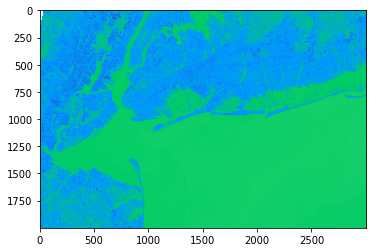

In [23]:
plt.imshow(TOA_Rad_b10[2000:4000, 1000:4000], cmap='terrain_r')
plt.show()

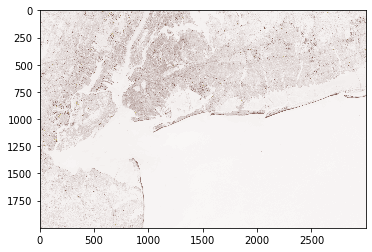

In [28]:
plt.imshow(TOA_Ref_b4[2000:4000, 1000:4000], cmap='terrain_r')
plt.show()

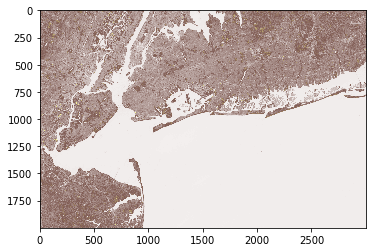

In [29]:
plt.imshow(TOA_Ref_b5[2000:4000, 1000:4000], cmap='terrain_r')
plt.show()

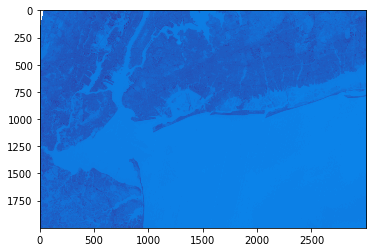

In [22]:
plt.imshow(BT_b10[2000:4000, 1000:4000], cmap='terrain_r')
plt.show()

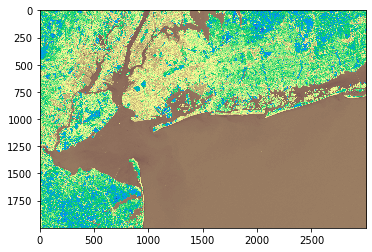

In [23]:
plt.imshow(NDVI[2000:4000, 1000:4000], cmap='terrain_r')
plt.show()

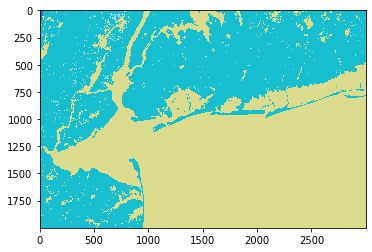

In [31]:
plt.imshow(LST[2000:4000, 1000:4000], cmap='tab20')
plt.show()